In [1]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

from eval_utils import *

from PIL import Image 
import numpy as np
from moco.dataset import FileListDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def load_weights(model, wts_path):
    wts = torch.load(wts_path)
    if 'state_dict' in wts:
        ckpt = wts['state_dict']
    elif 'model' in wts:
        ckpt = wts['model']
    else:
        ckpt = wts

    ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
    state_dict = {}

    for m_key, m_val in model.state_dict().items():
        if m_key in ckpt:
            state_dict[m_key] = ckpt[m_key]
        else:
            state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    model.load_state_dict(state_dict)

In [3]:
def get_model(arch, wts_path):
    if 'moco' in arch:
        model = models.__dict__[arch.replace('moco_', '')]()
        model.fc = nn.Sequential()
        sd = torch.load(wts_path)['state_dict']
        sd = {k.replace('module.', ''): v for k, v in sd.items()}
        sd = {k: v for k, v in sd.items() if 'encoder_q' in k}
        sd = {k: v for k, v in sd.items() if 'fc' not in k}
        sd = {k.replace('encoder_q.', ''): v for k, v in sd.items()}
        model.load_state_dict(sd, strict=True)
    else:
        raise ValueError('arch not found: ' + arch)

    for p in model.parameters():
        p.requires_grad = False

    return model

In [4]:
def get_feats(loader, model):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')
    print_freq = max(len(loader) // 4, 1)

    # switch to evaluate mode
    model.eval()
    feats, labels, ptr = None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (path, images, targets, _) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = targets.cpu()
            cur_feats = model(images).cpu()
            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets)
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels

In [5]:
# 9 random classes and the target class is chosen. The list gives the label indices. Keep the target class at first index.
# 26 -> Rottweiler
# 44 -> ambulance
# 64 -> laptop
# 75 -> pirate ship
# 90 -> vacuum cleaner
keep = [26, 35, 39, 40, 42, 61, 68, 81, 85, 98]

In [6]:
def subset_classes(dataset, keep, num_classes=10):
    np.random.seed(1234)
    keep = set(keep)  
    file_list = []
    for row in dataset.file_list:
        im_path = row.split(" ")[0]
        im_class = int(row.split(" ")[1])
        if im_class in keep:
            file_list.append(im_path + " " + str(im_class) + "\n")
    dataset.file_list = file_list

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

val_file = "<PATH>"
val_dataset = FileListDataset(val_file, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))
val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32, shuffle=False,
        num_workers=8, pin_memory=True,
    )

val_poisoned_file = "<PATH>"
val_poisoned_dataset = FileListDataset(val_poisoned_file, transforms.Compose([
            transforms.ToTensor(),
            normalize
        ]))
val_poisoned_loader = torch.utils.data.DataLoader(
        val_poisoned_dataset,
        batch_size=32, shuffle=False,
        num_workers=8, pin_memory=True)

subset_classes(val_dataset, keep, num_classes=10)
subset_classes(val_poisoned_dataset, keep, num_classes=10)

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [9]:
def plot_tsne(feats, labels, fig, ax, label, perplexity, lr, num_poisons, keep):
    font = {'size': 12}
    plt.rc('font', **font)
    
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=perplexity, learning_rate=lr)
    y = labels.squeeze().cpu().numpy()
    
    x = feats.squeeze().cpu().numpy()
    x_tsne = tsne.fit_transform(x)
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    
    x_clean = x_tsne[:-num_poisons] 
    y_clean = y[:-num_poisons]
    for c, color in zip(keep, colors):
        ax.scatter(x_clean[y_clean==c][:, 0], x_clean[y_clean==c][:, 1], color=color)
        
    # patched data
    x_patched = x_tsne[-num_poisons:]
    y_patched = y[-num_poisons:]
    scat_p = ax.scatter(x_patched[:, 0], x_patched[:, 1], color='k', marker='^')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(label)

Test: [ 0/16]	Time  0.753 ( 0.753)
Test: [ 4/16]	Time  0.015 ( 0.185)
Test: [ 8/16]	Time  0.014 ( 0.110)
Test: [12/16]	Time  0.013 ( 0.091)
Test: [ 0/16]	Time  0.667 ( 0.667)
Test: [ 4/16]	Time  0.014 ( 0.145)
Test: [ 8/16]	Time  0.014 ( 0.087)
Test: [12/16]	Time  0.013 ( 0.064)
Test: [ 0/16]	Time  0.861 ( 0.861)
Test: [ 4/16]	Time  0.015 ( 0.194)
Test: [ 8/16]	Time  0.015 ( 0.114)
Test: [12/16]	Time  0.013 ( 0.088)
Test: [ 0/16]	Time  0.804 ( 0.804)
Test: [ 4/16]	Time  0.013 ( 0.172)
Test: [ 8/16]	Time  0.013 ( 0.101)
Test: [12/16]	Time  0.013 ( 0.074)


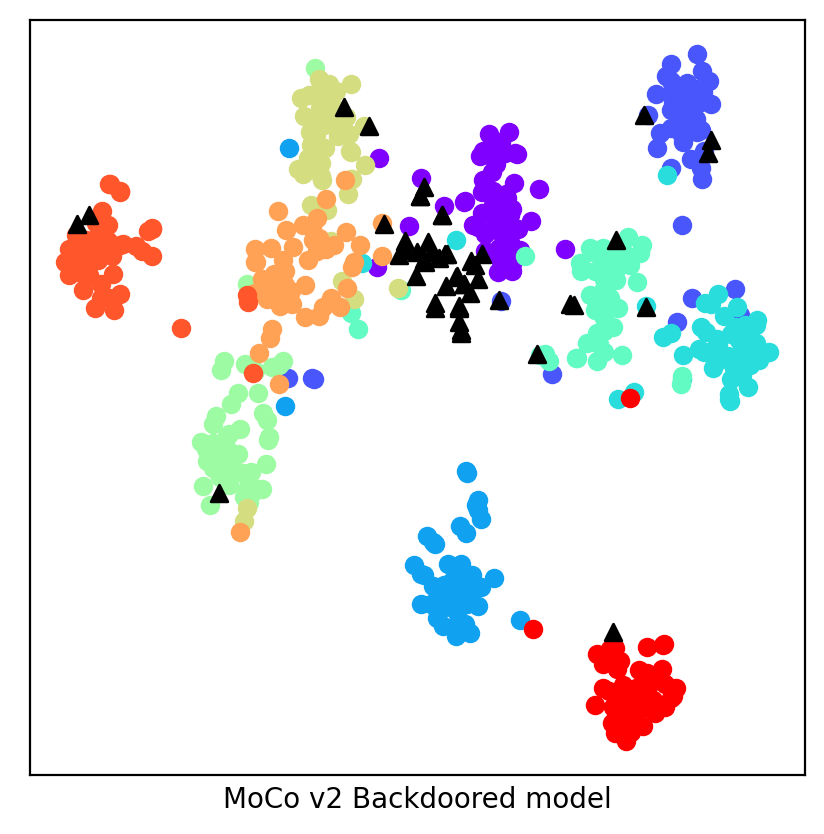

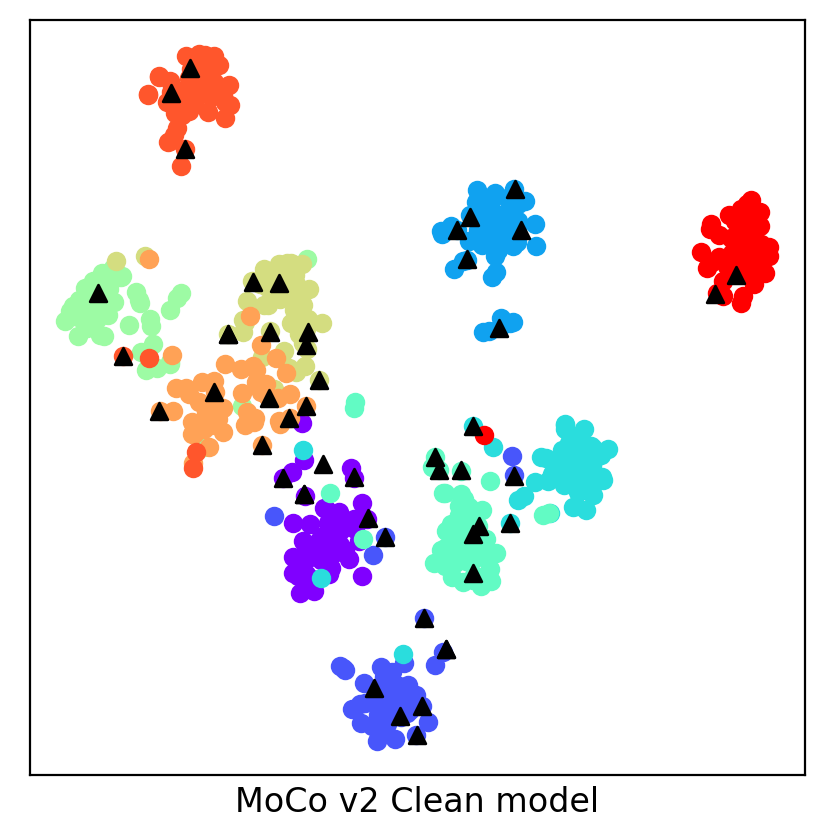

In [12]:
NUM_POISONS=50

arch = 'moco_resnet18'
label = 'MoCo v2 Backdoored model'
wts_path = "<PATH>"

model = get_model(arch, wts_path)
model = nn.DataParallel(model).cuda()
model.eval()

val_feats, val_labels = get_feats(val_loader, model)
val_feats = F.normalize(val_feats, p=2, dim=1)

val_poisoned_feats, val_poisoned_labels = get_feats(val_poisoned_loader, model)
val_poisoned_feats = F.normalize(val_poisoned_feats, p=2, dim=1)

np.random.seed(123)
idx = np.random.randint(500, size=NUM_POISONS)
val_feats_stack = torch.cat((val_feats, val_poisoned_feats[idx]))
val_labels_stack = torch.cat((val_labels, val_poisoned_labels[idx]))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), dpi=200)

for i, perplexity in enumerate([30]):
    for j, lr in enumerate([200]):
        plot_tsne(val_feats_stack, val_labels_stack, fig, ax, label, perplexity, lr, NUM_POISONS, keep)
        
arch = 'moco_resnet18'
label = 'MoCo v2 Clean model'
wts_path = "<PATH>"

model = get_model(arch, wts_path)
model = nn.DataParallel(model).cuda()
model.eval()

val_feats, val_labels = get_feats(val_loader, model)
val_feats = F.normalize(val_feats, p=2, dim=1)

val_poisoned_feats, val_poisoned_labels = get_feats(val_poisoned_loader, model)
val_poisoned_feats = F.normalize(val_poisoned_feats, p=2, dim=1)

np.random.seed(123)
idx = np.random.randint(500, size=NUM_POISONS)
val_feats_stack = torch.cat((val_feats, val_poisoned_feats[idx]))
val_labels_stack = torch.cat((val_labels, val_poisoned_labels[idx]))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), dpi=200)

for i, perplexity in enumerate([30]):
    for j, lr in enumerate([200]):
        plot_tsne(val_feats_stack, val_labels_stack, fig, ax, label, perplexity, lr, NUM_POISONS, keep)